# Test

100%|██████████| 54/54 [00:02<00:00, 26.35it/s]


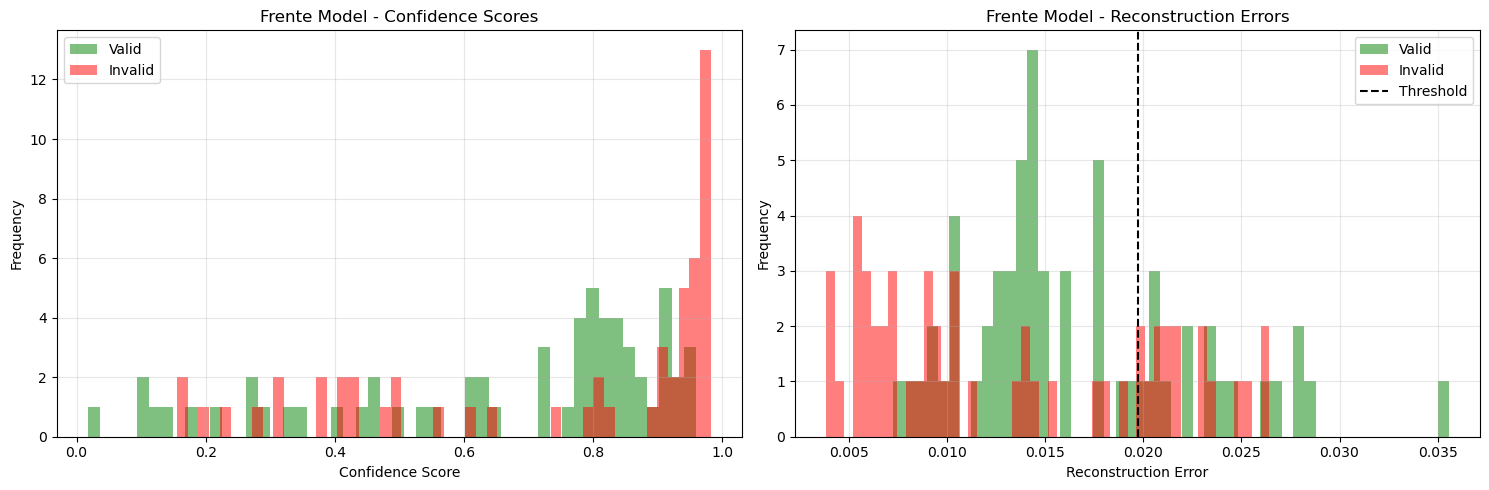


Frente Model Statistics:
Valid - Mean Confidence: 0.657
Invalid - Mean Confidence: 0.740
Valid - Mean Error: 0.017
Invalid - Mean Error: 0.013
Threshold: 0.020


100%|██████████| 48/48 [00:01<00:00, 24.85it/s]


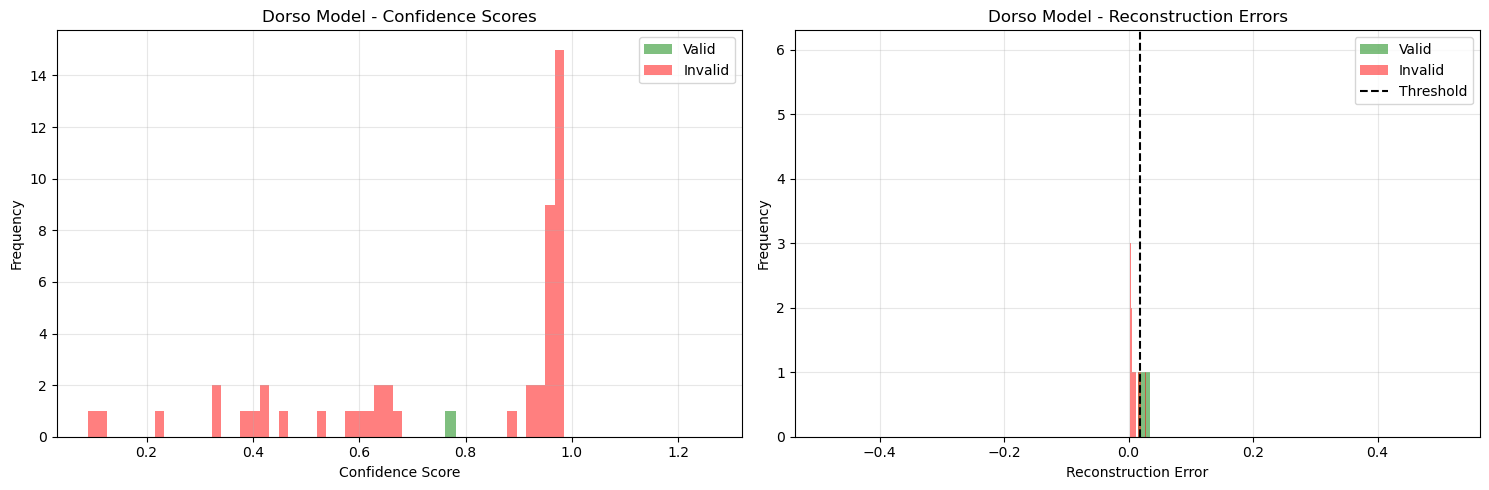


Dorso Model Statistics:
Valid - Mean Confidence: 0.761
Invalid - Mean Confidence: 0.764
Valid - Mean Error: 0.014
Invalid - Mean Error: 0.011
Threshold: 0.019


In [1]:
import shutil
import torch
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from torch.utils.data import DataLoader
from autoencoder import DNIAnomalyDetector, DNIDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

def preprocess_images_with_yolo(yolo_model, input_dir, output_dir, global_output_dir=None, invalid_labels=None):
    """
    Detect, crop, and ensure horizontal orientation of DNI images using YOLO.

    Args:
        yolo_model: YOLO model for detection.
        input_dir: Directory containing input images.
        output_dir: Directory to save processed images for this input_dir.
        global_output_dir: Directory to save all cropped images globally.
        invalid_labels: List of labels to ignore during processing.
    """
    invalid_labels = invalid_labels or ['no_match']
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    if global_output_dir:
        Path(global_output_dir).mkdir(parents=True, exist_ok=True)

    image_paths = list(Path(input_dir).glob('*.jpg'))
    for img_path in tqdm(image_paths, desc=f"Processing {input_dir}"):
        try:
            results = yolo_model(str(img_path), verbose=False)[0]
            if not results.boxes:  # Skip if no detection
                continue

            # Get the best detection
            best_box = results.boxes[results.boxes.conf.argmax()]
            cls_name = results.names[int(best_box.cls.item())]
            if cls_name in invalid_labels:
                continue

            # Crop and reorient image
            bbox = best_box.xyxy[0].cpu().numpy()
            cropped_image = crop_and_reorient_image(Image.open(img_path), bbox)

            # Save to output directories
            cropped_image.save(Path(output_dir) / img_path.name)
            if global_output_dir:
                cropped_image.save(Path(global_output_dir) / img_path.name)

        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")

def crop_and_reorient_image(image, bbox):
    """
    Crop and ensure the image is horizontal (width > height).

    Args:
        image: PIL Image to process.
        bbox: Bounding box [x1, y1, x2, y2].

    Returns:
        A cropped and correctly oriented PIL Image.
    """
    x1, y1, x2, y2 = map(int, bbox)
    cropped_image = image.crop((x1, y1, x2, y2))

    # Ensure horizontal orientation
    if cropped_image.height > cropped_image.width:
        cropped_image = cropped_image.rotate(90, expand=True)
    
    return cropped_image

def crop_image(image, bbox):
    """Crop image using bounding box coordinates."""
    x1, y1, x2, y2 = map(int, bbox)
    return image.crop((x1, y1, x2, y2))

def compute_reconstruction_stats(detector, data_dir, batch_size=32):
    dataset = DNIDataset(data_dir, detector.transform)
    confidences = []
    errors = []
    
    for img_path in tqdm(dataset.image_paths):
        confidence, error = detector.predict(img_path)
        confidences.append(confidence)
        errors.append(error)
        
    return np.array(confidences), np.array(errors)

def plot_distributions(valid_conf, invalid_conf, valid_err, invalid_err, threshold, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confidence plot
    ax1.hist(valid_conf, bins=50, alpha=0.5, label='Valid', color='green')
    ax1.hist(invalid_conf, bins=50, alpha=0.5, label='Invalid', color='red')
    ax1.set_title(f'{title} - Confidence Scores')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Error plot
    ax2.hist(valid_err, bins=50, alpha=0.5, label='Valid', color='green')
    ax2.hist(invalid_err, bins=50, alpha=0.5, label='Invalid', color='red')
    ax2.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    ax2.set_title(f'{title} - Reconstruction Errors')
    ax2.set_xlabel('Reconstruction Error')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_model_statistics(model_name, valid_conf, invalid_conf, valid_err, invalid_err, threshold):
    print(f"\n{model_name} Model Statistics:")
    print(f"Valid - Mean Confidence: {valid_conf.mean():.3f}")
    print(f"Invalid - Mean Confidence: {invalid_conf.mean():.3f}")
    print(f"Valid - Mean Error: {valid_err.mean():.3f}")
    print(f"Invalid - Mean Error: {invalid_err.mean():.3f}")
    print(f"Threshold: {threshold:.3f}")

def process_and_evaluate(yolo_model_path, models_info, test_dirs):
    yolo_model = YOLO(yolo_model_path)
    
    for model_type, model_path in models_info.items():
        # Create temp directories for processed images
        temp_valid = f'temp_valid_{model_type}'
        temp_invalid = f'temp_invalid_{model_type}'
        
        # Process images with YOLO
        preprocess_images_with_yolo(yolo_model, test_dirs[f'valid{model_type}'], temp_valid)
        preprocess_images_with_yolo(yolo_model, test_dirs[f'invalid{model_type}'], temp_invalid)
        
        # Load and evaluate autoencoder
        model = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
        model.load_model(model_path)
        
        valid_conf, valid_err = compute_reconstruction_stats(model, temp_valid)
        invalid_conf, invalid_err = compute_reconstruction_stats(model, temp_invalid)
        
        plot_distributions(valid_conf, invalid_conf, valid_err, invalid_err, 
                         model.threshold, f"{model_type} Model")
        print_model_statistics(model_type, valid_conf, invalid_conf, valid_err, 
                             invalid_err, model.threshold)
        
        # Cleanup
        shutil.rmtree(temp_valid)
        shutil.rmtree(temp_invalid)

# Usage
process_and_evaluate(
    yolo_model_path='api/best.pt',
    models_info={
        'Frente': 'models/dni_anomaly_detector_frente.pt',
        'Dorso': 'models/dni_anomaly_detector_dorso.pt'
    },
    test_dirs={
        'validFrente': 'test/original/valid_frente',
        'invalidFrente': 'test/original/invalid_frente',
        'validDorso': 'test/original/valid_dorso',
        'invalidDorso': 'test/original/invalid_dorso'
    }
)

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

def test_autoencoder(model, image_path, save_path=None):
    """
    Test the autoencoder by reconstructing an image and visualizing the results.
    
    Args:
        model: DNIAnomalyDetector instance
        image_path: Path to the test image
        save_path: Optional path to save the visualization
    """
    # Prepare image
    image = Image.open(image_path).convert('RGB')
    image_tensor = model.transform(image).unsqueeze(0).to(model.device)
    
    # Get reconstruction
    model.encoder.eval()
    model.decoder.eval()
    with torch.no_grad():
        latent = model.encoder(image_tensor)
        reconstructed = model.decoder(latent)
    
    # Calculate reconstruction error
    mse_loss = torch.nn.functional.mse_loss(reconstructed, image_tensor).item()
    
    # Convert tensors to images for plotting
    original_img = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    reconstructed_img = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original
    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Plot reconstruction
    axes[1].imshow(reconstructed_img)
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    
    # Plot error map
    error_map = np.abs(original_img - reconstructed_img).mean(axis=2)
    im = axes[2].imshow(error_map, cmap='hot')
    axes[2].set_title(f'Error Map\nMSE: {mse_loss:.6f}')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    return mse_loss

# Cargar el modelo entrenado
detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
detector.load_model('dni_anomaly_detector_old.pt')

# Test de una sola imagen
test_autoencoder(detector, 'test/valid/0a1e89f6-0ae2-4cab-854e-61c897cbbe13.jpg', save_path='resultado.png')

# test_autoencoder(detector, 'test/invalid/DniFrente 1.jpg', save_path='resultado.png')

# # Test de múltiples imágenes
# results = batch_test(detector, 'carpeta/con/imagenes', n_samples=5)

In [ ]:
detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
detector.load_model('dni_anomaly_detector_old.pt')

detector.threshold